In [1]:
import pandas as pd
import numpy as np
from pandas import read_excel
import os

from collections import Counter
import tensorflow as tf
import keras as ks
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
from nltk.util import ngrams
import re
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('Text+Image - Sheet1.csv')
display(df)
df['GENRE'] = df['GENRE'].astype('category')
df.info()
df.dropna(inplace=True)
print(df.shape)
df['Image'] = df['Image'].str.strip()
df['Final'] = df['Final'].str.strip()


,Final,GENRE,Image
0,১০১০ গাণিতিক কুইজ,0.0,১০১০ গাণিতিক কুইজ.png
1,গাণিতিক সংখার মজার অংক,0.0,গাণিতিক সংখার মজার অংক.png
2,১১৮ টি মৌলের ইতিবৃত্ত,0.0,১১৮ টি মৌলের ইতিবৃত্ত.png
3,420 গণিত,0.0,420 গণিত.png
4,৫০৫ গাণিতিক কুইজ,0.0,৫০৫ গাণিতিক কুইজ.png
...,...,...,...
4527,অতীন্দ্রিয় উপন্যাস,3.0,অতীন্দ্রিয়.png
4528,রম্যরচনা সংগ্রহ,3.0,রম্যরচনা সংগ্রহ বনফুল.jpg
4529,মুখোশ একটি নদীর উপন্যাস,3.0,মুখোশ একটি নদীর নাম.jpg
4530,মা অক্সিজেন রচনা,3.0,আম্মার অক্সিজেন.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4532 entries, 0 to 4531
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Final   4532 non-null   object  
 1   GENRE   4530 non-null   category
 2   Image   4325 non-null   object  
dtypes: category(1), object(2)
memory usage: 75.6+ KB
(4323, 3)


In [3]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    #punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    punctuations = '''````£|¢|Ñ+-*/=EROero৳012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [4]:
df['Final'] = df.Final.apply(lambda x: preprocessing(str(x)))
display(df)

,Final,GENRE,Image
0,১০১০ গাণিতিক কুইজ,0.0,১০১০ গাণিতিক কুইজ.png
1,গাণিতিক সংখার মজার অংক,0.0,গাণিতিক সংখার মজার অংক.png
2,১১৮ টি মৌলের ইতিবৃত্ত,0.0,১১৮ টি মৌলের ইতিবৃত্ত.png
3,গণিত,0.0,420 গণিত.png
4,৫০৫ গাণিতিক কুইজ,0.0,৫০৫ গাণিতিক কুইজ.png
...,...,...,...
4527,অতীন্দ্রিয় উপন্যাস,3.0,অতীন্দ্রিয়.png
4528,রম্যরচনা সংগ্রহ,3.0,রম্যরচনা সংগ্রহ বনফুল.jpg
4529,মুখোশ একটি নদীর উপন্যাস,3.0,মুখোশ একটি নদীর নাম.jpg
4530,মা অক্সিজেন রচনা,3.0,আম্মার অক্সিজেন.jpg


In [5]:
import BnLemma as lm
from collections import Counter

bl = lm.Lemmatizer()
lemmatized_words_counter = Counter()
transformation_counter = Counter()
custom_transformations = {
    "হিস্ট্রি" : "ইতিহাস",
    "ইতিহাসের" : "ইতিহাস",
    "অঙ্ক": "গণিত",
    "অঙ্কের": "গণিত",
    "গাণিতিক" : "গণিত",
    "অংকের" : "গণিত",
    "রাজ্যে": "রাজ্য",
    "চাচা": "চাচা",
    "কৈশোর" : "ছোট",
    "কৈশোরের" : "ছোট",
    "কৈশোরী" : "ছোট",
    "কৈশোরীর" : "ছোট",
    "কৈশোরদের" : "ছোট",
    "কৈশোর" : "ছোট",
    "শিশু" : "ছোট",
    "ছোট্ট" : "ছোট",
    "ছোটদার" : "ছোট",
    "শিশুর" : "ছোট",
    "শিশুদের" : "ছোট",
    "বালক" : "ছোট",
    "বালকের" : "ছোট",
    "বালিকা" : "ছোট",
    "বালিকার" : "ছোট",
    "ছোটদের" : "ছোট",
    "ছোট" : "ছোট",
    "কমিক্স" : "কমিকস",
    "গ্রাফিক" : "কমিকস",
    "কমিক্সের" : "কমিকস",
    "কমিকস" : "কমিকস",
    "কার্টুন" : "কমিকস",
    "কমিক্‌স" : "কমিকস",
    "গুড্ডুবুড়া": "কমিকস",
    "টিনটিন" : "কমিকস",
    "সিসিমপুরে": "কমিকস",
    "সিসিমপুর" : "কমিকস",
    "টিনটিনের" : "কমিকস",
    "টিনটিনে" : "কমিকস",
    "টমের " : "কমিকস",
    "জেরি" : "কমিকস",
    "টম" : "কমিকস",
    "ডোরেমন" : "কমিকস",
    "ডোরেমনের" : "কমিকস",
    "সিনডেরেলা": "কমিকস",
    "সিনডেরেলার" : "কমিকস",
    "বেসিক আলী" : "কমিকস",
    "নোমান" : "কমিকস",
    "বাবু" : "কমিকস",
    "গুবলে" : "কমিকস",
    "সিনডরেলা" : "কমিকস",
    "প্যারাহীন" : "কমিকস",
    "ডোরা" : "কমিকস",
    "স্পাইডারম্যান" : "কমিকস",
    "স্পাইডারম্যানের" : "কমিকস",
    "ডোরার" : "কমিকস",
    "জাদুকর" : "জাদু",
    "পশুপাখির" : "প্রাণি",
    "বাঘরা" : "প্রাণি",
    "ব্যাঙ" : "প্রাণি",
    "বাঘ" : "প্রাণি",
    "মাছের" : "প্রাণি",
    "শালিকছানা" : "পাখি",
    "হাঁস" : "পাখি",
    "পাখির" : "পাখি",
    "পাখি" : "পাখি",
    "পাখিদের": "পাখি",
    "ময়নাপাখি": "পাখি",
    "ময়না" : "পাখি",
    "শালিক" : "পাখি",
    "বুবলিদের" : "পাখি",
    "বুবলি" : "পাখি",
    "পিঁপড়ে" : "প্রাণি",
    "পায়রা" : "পাখি",
    "পায়রার" : "পাখি",
    "ফড়িং" : "পাখি",
    "ফড়িংর" : "পাখি",
    "প্রজাপতি" : "পাখি",
    "প্রজাপতির" : "পাখি",
    "টিয়া" : "পাখি",
    "ইঁদুর" : "প্রাণি",
    "বিড়াল" : "প্রাণি",
    "বিড়ালের" : "প্রাণি",
    "বিড়ালদের" : "প্রাণি",
    "বিড়ালেরা" : "প্রাণি",
    "কাঠবিড়ালির" : "প্রাণি",
    "নেকড়ে" : "প্রাণি",
    "নেকড়ের" : "প্রাণি",
    "বাদুড়ের" : "প্রাণি",
    "বাদুড়" : "প্রাণি",
    "কাঠবিড়াল" : "প্রাণি",
    "জলপরি" : "প্রাণি",
    "পরী" : "প্রাণি",
    "পরি" : "প্রাণি",
    "পরির" : "প্রাণি",
    "পরীর" : "প্রাণি",
    "ব্যাঙের" : "প্রাণি",
    "ব্যাঙ" : "প্রাণি",
    "হাতি": "প্রাণি",
    "হাতির": "প্রাণি",
    "তেলাপোকা": "প্রাণি",
    "মাছ": "প্রাণি",
    "সিংহ": "প্রাণি",
    "হনুমান" : "প্রাণি",
    "হনুমানের" : "প্রাণি",
    "বানর" : "প্রাণি",
    "বানরের" : "প্রাণি",
    "কুমিরের " : "প্রাণি",
    "কুমির" : "প্রাণি",
    "যাদুকরের" : "জাদু",
    "যাদুকর" : "জাদু",
    "প্রেম" : "ভালোবাসা",
    "প্রেমের" : "ভালোবাসা",
    "প্রেমে" : "ভালোবাসা",
    "প্রেমের" : "ভালোবাসা",
    "ভালোবাসা" : "ভালোবাসা",
    "ভালোবাসার" : "ভালোবাসা",
    "ভালোবাসায়" : "ভালোবাসা",
    "প্রিয়তমা" : "ভালোবাসা",
    "লাভিং" : "ভালোবাসা",
    "প্রিয়তমার" : "ভালোবাসা",
    "রচনাবলি" : "গল্প",
    "রচনাবলী " : "গল্প",
    "রচনাসমগ্র" : "গল্প",
    "হরর" : "ভয়",
    "ভূত" : "ভয়",
    "যকের" : "ভয়",
    "ছোটগল্প" : "গল্প",
    "কাব্য" : "কবিতা",
    "জননী" : "মা",
}

def lemmatize_sentence(sentence):
    try:
        words = sentence.split()
        lemmatized_words = []
        for word in words:
            #lemma_word = bl.lemma(word)
            if word in custom_transformations:
                #print(f"Original: {word}, Lemmatized: {custom_transformations[word]}")
                lemma_word = custom_transformations[word]
            else:
                lemma_word = bl.lemma(word)
            if word != lemma_word:
                transformation_counter[(word, lemma_word)] += 1
                lemmatized_words_counter[lemma_word] += 1
                #print(f"Original: {word}, Lemmatized: {lemma_word}")  # Print the transformation
            lemmatized_words.append(lemma_word)
        return ' '.join(lemmatized_words)
    except KeyError as e:
        print(f"KeyError: {e} for sentence: {sentence}")
        return sentence


df['Final'] = df['Final'].apply(lemmatize_sentence)


# Total number of lemmatized words
total_lemmatized_words = sum(lemmatized_words_counter.values())


print(f"Total number of lemmatized words: {total_lemmatized_words}")

top_40_lemmatized_words = lemmatized_words_counter.most_common(40)
print("\nTop 60 lemmatized words:")
for word, count in top_40_lemmatized_words:
    print(f"{word}: {count} times")



top_40_transformations = transformation_counter.most_common(40)
print("\nTop 40 transformations:")
for (original, transformed), count in top_40_transformations:
    print(f"{original} ->{transformed}: {count}")


KeyError: '' for sentence: মুক্তিযুদ্ধের বয়ানে ইসলাম
Total number of lemmatized words: 5966

Top 60 lemmatized words:
বিজ্ঞান: 150 times
গণিত: 117 times
কমিকস: 114 times
প্রাণি: 82 times
গল্প: 80 times
মজা: 74 times
বাংলাদেশ: 68 times
ভালোবাসা: 57 times
মহাবিশ্বে: 40 times
ইতিহাস: 40 times
ছোট: 39 times
বাংলা: 36 times
জীবন: 34 times
মুক্তিযুদ্ধ: 32 times
রাজনীতি: 32 times
দেশ: 31 times
হওয়া: 29 times
রহস্য: 28 times
ভারত: 28 times
জানা: 26 times
হাত: 26 times
সমগ্র: 26 times
বঙ্গবন্ধু: 26 times
বাঙালি: 26 times
পাখি: 25 times
দিন: 24 times
সভ্য: 24 times
জাদু: 23 times
মা: 23 times
ভয়: 23 times
এ: 22 times
পদার্থ: 22 times
নির্বাচক: 22 times
সোনা: 21 times
ভূত: 21 times
প্রাণ: 20 times
বিশ্ব: 20 times
যাওয়া: 20 times
স্বাধীন: 20 times
করা: 19 times

Top 40 transformations:
মজার ->মজা: 72
বিজ্ঞানের ->বিজ্ঞান: 67
গ্রাফিক ->কমিকস: 56
গণিতের ->গণিত: 55
বাংলাদেশের ->বাংলাদেশ: 52
গল্পে ->গল্প: 36
বাংলার ->বাংলা: 31
মহাবিশ্বের ->মহাবিশ্বে: 22
নির্বাচিত ->নির্বাচক: 22
গল্পসমগ্র ->সমগ্র: 21


In [6]:
from collections import Counter


category_list = df.GENRE.unique().tolist()

for i in category_list:
    temp = df.loc[df['GENRE'] == i].copy() 
    temp.loc[:, 'temp_list'] = temp['Final'].apply(lambda x: str(x).split())
    top = Counter([item for sublist in temp['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words', 'count']
    temp.style.background_gradient(cmap='Blues')
    temp = temp.style.set_caption('Top 20 Words In ' + str(i) + " Category")
    display(temp)

,Common_words,count
0,বিজ্ঞান,234
1,গণিত,228
2,ও,157
3,মজা,72
4,গল্প,56
5,মহাবিশ্বে,44
6,কথা,43
7,খণ্ড,39
8,অলিম্পিয়াড,35
9,প্রোগ্রামিং,34


,Common_words,count
0,কমিকস,123
1,প্রাণি,76
2,ও,73
3,আর,54
4,জাদু,47
5,ছবি,46
6,গল্প,45
7,ছোট,36
8,পাখি,32
9,রহস্য,19


,Common_words,count
0,ও,193
1,ইতিহাস,163
2,বাংলাদেশ,98
3,রাজনীতি,80
4,বঙ্গবন্ধু,68
5,মুক্তিযুদ্ধ,42
6,ভারত,40
7,দ্য,39
8,বাংলা,39
9,ঢাকা,35


,Common_words,count
0,গল্প,160
1,উপন্যাস,97
2,কবিতা,80
3,ভালোবাসা,63
4,সমগ্র,50
5,ও,44
6,জীবন,22
7,নির্বাচক,21
8,শ্রেষ্ঠ,20
9,ভয়,18


In [7]:
from collections import Counter


data1 = pd.read_excel('stopwords_bangla2.xlsx')
stop = data1['words'].tolist()


removed_stopwords_counter = Counter()


def stopwordRemoval(text):    
    words = str(text).split()  
    filtered_words = []       
    removed_stopwords = []     
    
    for word in words:
        if word not in stop:
            filtered_words.append(word)  
        else:
            removed_stopwords.append(word)  
            removed_stopwords_counter[word] += 1  
    
    
    return ' '.join(filtered_words)  


df['Final'] = df['Final'].apply(stopwordRemoval)

# Display the top 40 most common removed stopwords
top_40_removed_stopwords = removed_stopwords_counter.most_common(80)
print("Top 40 removed stopwords:")
for word, count in top_40_removed_stopwords:
    print(f"{word}: {count} times")



Top 40 removed stopwords:
ও: 467 times
দ্য: 86 times
আর: 73 times
থেকে: 54 times
এবং: 51 times
অব: 50 times
এ: 39 times
প্রথম: 36 times
দিন: 36 times
জানা: 34 times
জন্য: 31 times
হাত: 30 times
দেখা: 29 times
তিন: 27 times
শেষ: 25 times
না: 24 times
যে: 24 times
আমি: 22 times
বাড়ি: 22 times
উত্তর: 21 times
কেন: 21 times
করা: 21 times
যা: 20 times
যাওয়া: 20 times
লাল: 20 times
হ: 19 times
একটি: 19 times
সংখ্যা: 18 times
সাত: 18 times
বছর: 18 times
চার: 18 times
নাম: 18 times
কে: 17 times
কি: 17 times
আমাদের: 17 times
যখন: 17 times
পথ: 17 times
যত: 16 times
তারা: 16 times
কী: 15 times
শত: 15 times
হাজার: 15 times
শূন্য: 13 times
আজ: 12 times
এর: 12 times
দুই: 12 times
কত: 11 times
হায়: 11 times
ঘর: 11 times
বলা: 11 times
আপনার: 11 times
সব: 10 times
দেওয়া: 10 times
এস: 10 times
যায়: 10 times
মান: 9 times
উচ্চ: 9 times
থাকা: 9 times
পাঁচ: 9 times
কিছু: 8 times
আসা: 8 times
গা: 8 times
পারা: 8 times
তার: 8 times
অন্য: 7 times
নয়: 7 times
সবার: 7 times
নেই: 7 times
সমান: 7 times
গ্রহণ: 

In [8]:
df['Image'] = df['Image'].apply(lambda x: os.path.join('All_Image/', x))
display(df)

,Final,GENRE,Image
0,১০১০ গণিত কুইজ,0.0,All_Image/১০১০ গাণিতিক কুইজ.png
1,গণিত সংখার মজা অংক,0.0,All_Image/গাণিতিক সংখার মজার অংক.png
2,১১৮ মৌল বৃত্ত,0.0,All_Image/১১৮ টি মৌলের ইতিবৃত্ত.png
3,গণিত,0.0,All_Image/420 গণিত.png
4,৫০৫ গণিত কুইজ,0.0,All_Image/৫০৫ গাণিতিক কুইজ.png
...,...,...,...
4527,অতীন্দ্রিয় উপন্যাস,3.0,All_Image/অতীন্দ্রিয়.png
4528,রম্য সংগ্রহ,3.0,All_Image/রম্যরচনা সংগ্রহ বনফুল.jpg
4529,মুখোশ নদী উপন্যাস,3.0,All_Image/মুখোশ একটি নদীর নাম.jpg
4530,মা অক্সিজেন রচনা,3.0,All_Image/আম্মার অক্সিজেন.jpg


In [9]:
df = df.sample(frac=1).reset_index(drop=True)

In [10]:
temp1 = df.groupby('GENRE').count()['Final'].reset_index().sort_values(by='Final',ascending=False)
temp1.style.background_gradient(cmap='Purples')

/var/folders/zv/jrbwp45516zdz0j9bvpf13nh0000gn/T/ipykernel_82892/1747853096.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp1 = df.groupby('GENRE').count()['Final'].reset_index().sort_values(by='Final',ascending=False)


,GENRE,Final
0,0.000000,1131
2,2.000000,1107
1,1.000000,1073
3,3.000000,1012


In [11]:
X = df.drop('GENRE', axis=1)
y = df["GENRE"]

y = pd.get_dummies(y)

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=60)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=60)

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from PIL import Image
from skimage.util import img_as_float
import matplotlib.pyplot as plt

class MultiModalDataGenerator(Sequence):
    def __init__(self, df, labels, tokenizer, img_size=(224, 224), batch_size=16, max_length=8, shuffle=True, augment=True):
        self.df = df.reset_index(drop=True)  # Reset index for consistency
        self.labels_df = labels.reset_index(drop=True)  # Reset index for consistency
        self.tokenizer = tokenizer
        self.img_size = img_size
        self.batch_size = batch_size
        self.max_length = max_length
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.df))  # Create array of indices
        
        if self.augment:
            self.image_datagen = ImageDataGenerator(
                rotation_range=2,
                width_shift_range=0.01,
                height_shift_range=0.02,
                shear_range=0.0,
                zoom_range=0.2,
                horizontal_flip=True
            )
        else:
            self.image_datagen = ImageDataGenerator()

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_texts = []
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            batch_texts.append(self.df.at[i, 'Final'])
            img = Image.open(self.df.at[i, 'Image']).convert("RGB").resize(self.img_size)
            img_array = np.array(img)
            img_array = img_as_float(img_array)
            
            if self.augment:
                img_array = self.image_datagen.random_transform(img_array)
            
            batch_images.append(img_array)
            batch_labels.append(self.labels_df.loc[i].values)

        # Tokenize and pad text data
        sequences = self.tokenizer.texts_to_sequences(batch_texts)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post', truncating='post')

        # Convert images to numpy array
        batch_images = np.array(batch_images)

        # Convert labels to numpy array
        batch_labels = np.array(batch_labels, dtype='float32')

        return {'text_input': padded_sequences, 'image_input': batch_images}, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [14]:
vocab_size = 4000
embedding_dim = 400
max_length = 8
trunc_type='post'
oov_tok = "<OOV>"

In [15]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train['Final'])

In [16]:
train_generator = MultiModalDataGenerator(X_train, y_train, tokenizer, batch_size=16, max_length=max_length)

In [17]:
val_generator = MultiModalDataGenerator(X_val, y_val, tokenizer, batch_size=16, max_length=max_length,shuffle=False, augment=False)

In [18]:
test_generator = MultiModalDataGenerator(X_test, y_test, tokenizer, batch_size=16, max_length=max_length,shuffle=False, augment=False)

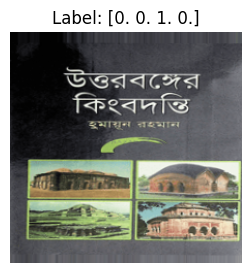

[[[0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  ...
  [0.30919982 0.32488609 0.3484155 ]
  [0.31913878 0.33482505 0.35835447]
  [0.33095811 0.34194964 0.36665274]]

 [[0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  ...
  [0.30929923 0.32498551 0.34851492]
  [0.31916363 0.33484991 0.35837932]
  [0.33115694 0.34204906 0.36677701]]

 [[0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  ...
  [0.30939865 0.32508492 0.34861433]
  [0.31918849 0.33487476 0.35840417]
  [0.33135577 0.34214848 0.36690128]]

 ...

 [[0.37482022 0.37034853 0.38321348]
  [0.33985985 0.34029872 0.35990656]
  [0.35628074 0.35775968 0.37981015]
  ...
  [0.56348753 0.56402818 0.57809252]
  [0.58835031 0.58835031 0.59484792]
  [0.56862991 0.57137476 0.58078603]]

 [[0.37452198 0.36995087 0.38301465]
  [0.33963616 0.3401496  0.35975744]


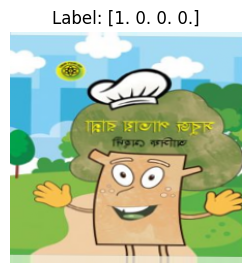

[[[0.79899    0.88785766 0.94143121]
  [0.86810056 0.94734512 0.98192229]
  [0.88194951 0.9605826  0.98411201]
  ...
  [0.87139    0.96078431 0.98431373]
  [0.87058824 0.96078431 0.98431373]
  [0.87314469 0.96078431 0.98175727]]

 [[0.80019806 0.88897943 0.94246669]
  [0.86870459 0.94781972 0.98209487]
  [0.88177693 0.96049631 0.98402572]
  ...
  [0.87134685 0.96078431 0.98431373]
  [0.87058824 0.96078431 0.98431373]
  [0.87318784 0.96078431 0.98171412]]

 [[0.7725571  0.87633754 0.93312378]
  [0.82907057 0.92583758 0.96783315]
  [0.83961427 0.93537849 0.96907001]
  ...
  [0.87130371 0.96078431 0.98431373]
  [0.87058824 0.96078431 0.98431373]
  [0.87323098 0.96078431 0.98167098]]

 ...

 [[0.73451932 0.89803922 0.69882987]
  [0.745439   0.89815287 0.70622331]
  [0.75635868 0.90179276 0.71714299]
  ...
  [0.74901961 0.89803922 0.70588235]
  [0.74841114 0.89803922 0.70649082]
  [0.74411766 0.89771242 0.70947713]]

 [[0.73464875 0.89803922 0.69891616]
  [0.74556843 0.89819601 0.70635275]


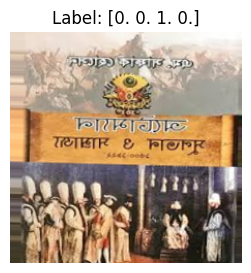

[[[0.9178525  0.84891689 0.78410829]
  [0.91804783 0.84881922 0.78391295]
  [0.91824317 0.84872155 0.78371762]
  ...
  [0.98828455 0.98828455 0.98044141]
  [0.98809488 0.98809488 0.98025174]
  [0.98792154 0.98792154 0.9800784 ]]

 [[0.91525508 0.85250999 0.79129448]
  [0.91515742 0.85241232 0.79109915]
  [0.91505975 0.85231465 0.79090381]
  ...
  [0.98823529 0.98823529 0.98039216]
  [0.98823529 0.98823529 0.98039216]
  [0.98823529 0.98823529 0.98039216]]

 [[0.91764706 0.85490196 0.79607843]
  [0.91764706 0.85490196 0.79607843]
  [0.91764706 0.85490196 0.79607843]
  ...
  [0.98823529 0.98823529 0.98039216]
  [0.98823529 0.98823529 0.98039216]
  [0.98823529 0.98823529 0.98039216]]

 ...

 [[0.25068874 0.2270135  0.14117647]
  [0.2504934  0.2267205  0.14117647]
  [0.25029807 0.2264275  0.14117647]
  ...
  [0.1719029  0.15621662 0.14445192]
  [0.17151223 0.15582596 0.14406125]
  [0.17112156 0.15543529 0.14367058]]

 [[0.23374404 0.20676736 0.13083466]
  [0.23423237 0.20735336 0.13112766]


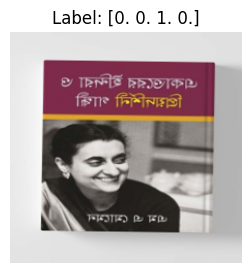

[[[0.89803922 0.89803922 0.89803922]
  [0.89803922 0.89803922 0.89803922]
  [0.89803922 0.89803922 0.89803922]
  ...
  [0.87843137 0.87843137 0.87843137]
  [0.87843137 0.87843137 0.87843137]
  [0.87843137 0.87843137 0.87843137]]

 [[0.89803922 0.89803922 0.89803922]
  [0.89803922 0.89803922 0.89803922]
  [0.89803922 0.89803922 0.89803922]
  ...
  [0.87843137 0.87843137 0.87843137]
  [0.87843137 0.87843137 0.87843137]
  [0.87843137 0.87843137 0.87843137]]

 [[0.89803922 0.89803922 0.89803922]
  [0.89803922 0.89803922 0.89803922]
  [0.89803922 0.89803922 0.89803922]
  ...
  [0.87843137 0.87843137 0.87843137]
  [0.87843137 0.87843137 0.87843137]
  [0.87843137 0.87843137 0.87843137]]

 ...

 [[0.89019608 0.89019608 0.89019608]
  [0.89019608 0.89019608 0.89019608]
  [0.89019608 0.89019608 0.89019608]
  ...
  [0.86666667 0.86666667 0.86666667]
  [0.86666667 0.86666667 0.86666667]
  [0.86666667 0.86666667 0.86666667]]

 [[0.89019608 0.89019608 0.89019608]
  [0.89019608 0.89019608 0.89019608]


In [19]:
batch_x, batch_y = train_generator[0]

texts = batch_x['text_input']
images = batch_x['image_input']
labels = batch_y

for i in range(5,9):
    plt.figure(figsize=(6, 3))
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"Label: {labels[i]}")

    plt.show()

    print(images[i])
    print(f"Text: {texts[i]}")
    print(f"Text shape: {texts[i].shape}")

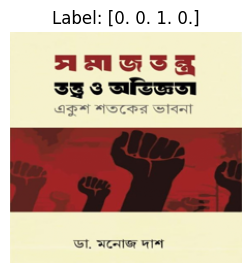

[[[0.96862745 0.95294118 0.81568627]
  [0.96862745 0.95294118 0.81568627]
  [0.96862745 0.95294118 0.81568627]
  ...
  [0.96470588 0.95686275 0.80784314]
  [0.96078431 0.94901961 0.81960784]
  [0.95686275 0.95294118 0.85882353]]

 [[0.96862745 0.95294118 0.81568627]
  [0.96862745 0.95294118 0.81568627]
  [0.96862745 0.95294118 0.81568627]
  ...
  [0.96078431 0.95294118 0.80392157]
  [0.96470588 0.94901961 0.81960784]
  [0.96078431 0.95686275 0.8627451 ]]

 [[0.96470588 0.94901961 0.81176471]
  [0.96470588 0.94901961 0.81176471]
  [0.96470588 0.94901961 0.81176471]
  ...
  [0.96078431 0.95294118 0.80784314]
  [0.96470588 0.94901961 0.82352941]
  [0.96470588 0.96078431 0.8627451 ]]

 ...

 [[0.96862745 0.95294118 0.81568627]
  [0.96078431 0.94901961 0.8       ]
  [0.96470588 0.95294118 0.78823529]
  ...
  [0.96078431 0.94509804 0.8       ]
  [0.96078431 0.94509804 0.8       ]
  [0.96078431 0.9372549  0.79607843]]

 [[0.97254902 0.95686275 0.81960784]
  [0.96470588 0.94901961 0.8       ]


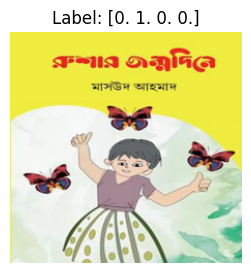

[[[0.94117647 0.92941176 0.25098039]
  [0.94117647 0.92941176 0.25098039]
  [0.94117647 0.92941176 0.25098039]
  ...
  [0.94117647 0.92941176 0.25098039]
  [0.94117647 0.92941176 0.25098039]
  [0.94117647 0.92941176 0.25098039]]

 [[0.94117647 0.92941176 0.25098039]
  [0.94117647 0.92941176 0.25098039]
  [0.94117647 0.92941176 0.25098039]
  ...
  [0.94117647 0.92941176 0.25098039]
  [0.94117647 0.92941176 0.25098039]
  [0.94117647 0.92941176 0.25098039]]

 [[0.94117647 0.92941176 0.25098039]
  [0.94117647 0.92941176 0.25098039]
  [0.94117647 0.92941176 0.25098039]
  ...
  [0.94117647 0.92941176 0.25098039]
  [0.94117647 0.92941176 0.25098039]
  [0.94117647 0.92941176 0.25098039]]

 ...

 [[0.88627451 0.91372549 0.52941176]
  [0.88627451 0.91372549 0.64313725]
  [0.88235294 0.89803922 0.83529412]
  ...
  [0.49803922 0.78039216 0.63529412]
  [0.49803922 0.77647059 0.63921569]
  [0.49803922 0.77647059 0.64313725]]

 [[0.87843137 0.90588235 0.52941176]
  [0.89803922 0.92156863 0.65490196]


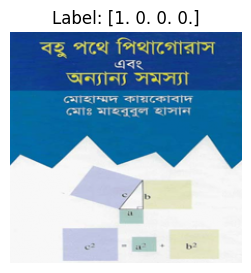

[[[0.05098039 0.2627451  0.58039216]
  [0.0627451  0.25098039 0.57647059]
  [0.06666667 0.25098039 0.55686275]
  ...
  [0.09411765 0.25098039 0.51764706]
  [0.10196078 0.25098039 0.5254902 ]
  [0.09019608 0.24313725 0.52941176]]

 [[0.04705882 0.25882353 0.57254902]
  [0.05882353 0.24705882 0.56862745]
  [0.0627451  0.24313725 0.55686275]
  ...
  [0.0745098  0.25098039 0.50588235]
  [0.0745098  0.23137255 0.50196078]
  [0.06666667 0.23921569 0.52156863]]

 [[0.04313725 0.25490196 0.56862745]
  [0.05490196 0.24313725 0.56078431]
  [0.05882353 0.23921569 0.55686275]
  ...
  [0.07843137 0.26666667 0.50980392]
  [0.07058824 0.24705882 0.50196078]
  [0.05098039 0.23921569 0.50588235]]

 ...

 [[0.97254902 0.97254902 0.97254902]
  [0.97254902 0.97254902 0.97254902]
  [0.97254902 0.97254902 0.97254902]
  ...
  [0.95686275 0.95686275 0.95686275]
  [0.95686275 0.95686275 0.95686275]
  [0.95686275 0.95686275 0.95686275]]

 [[0.97254902 0.97254902 0.97254902]
  [0.97254902 0.97254902 0.97254902]


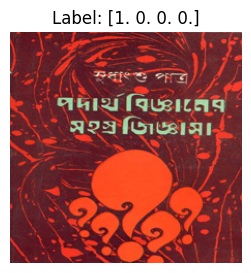

[[[0.47058824 0.16470588 0.18823529]
  [0.40392157 0.14509804 0.12941176]
  [0.36078431 0.11372549 0.10588235]
  ...
  [0.50980392 0.31372549 0.31764706]
  [0.52941176 0.32941176 0.3372549 ]
  [0.54901961 0.34901961 0.35686275]]

 [[0.40784314 0.10980392 0.15686275]
  [0.38039216 0.11372549 0.12941176]
  [0.38823529 0.12941176 0.14117647]
  ...
  [0.42352941 0.19215686 0.20784314]
  [0.41568627 0.18823529 0.20392157]
  [0.43529412 0.20784314 0.21960784]]

 [[0.32941176 0.09803922 0.17254902]
  [0.3372549  0.09803922 0.14901961]
  [0.38039216 0.12156863 0.15686275]
  ...
  [0.41568627 0.20392157 0.21176471]
  [0.4        0.18823529 0.2       ]
  [0.39215686 0.18431373 0.19215686]]

 ...

 [[0.40392157 0.12156863 0.16862745]
  [0.34509804 0.10980392 0.14117647]
  [0.36078431 0.16862745 0.18431373]
  ...
  [0.42352941 0.12941176 0.16862745]
  [0.41568627 0.13333333 0.16862745]
  [0.41568627 0.14509804 0.17254902]]

 [[0.43529412 0.15294118 0.2       ]
  [0.34901961 0.11372549 0.14509804]


In [20]:
batch_x, batch_y = test_generator[0]

texts = batch_x['text_input']
images = batch_x['image_input']
labels = batch_y

for i in range(5,9):
    plt.figure(figsize=(6, 3))
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"Label: {labels[i]}")

    plt.show()

    print(images[i])
    print(f"Text: {texts[i]}")
    print(f"Text shape: {texts[i].shape}")

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv2D, MaxPooling2D, Flatten, Embedding, Concatenate, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import efficientnet.keras as efn
from tensorflow.keras import regularizers

In [23]:
def create_multimodal_model(vocab_size, max_length, img_shape, num_classes):
    # LSTM text input model
    text_input = Input(shape=(max_length,), name='text_input')
    text_model = Sequential([
        Embedding(vocab_size, 100, input_length=max_length),
        LSTM(32, return_sequences=True),
        Dropout(0.4),
        LSTM(32),
        Dense(32, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
        Dropout(0.4),
    ])(text_input)

    # Pre-trained EfficientNetB0 for image input model
    base_model = efn.EfficientNetB0(include_top=False, input_shape=img_shape)
    base_model.trainable = True

    image_input = Input(shape=img_shape, name='image_input')
    enf_50_output = base_model(image_input)

    # Flatten VGG output for concatenation
    enf_50_flatten = Flatten()(enf_50_output)
    #enf_50_flatten = GlobalAveragePooling2D()(vgg_output)

    concatenated = Concatenate()([text_model, enf_50_flatten])

    # Fully connected layers after concatenation
    dense1 = Dense(128, activation='relu')(concatenated)
    dropout = Dropout(0.4)(dense1)
    output = Dense(num_classes, activation='softmax')(dropout)

    # Create final model
    model = Model(inputs=[text_input, image_input], outputs=output)

    return model


In [24]:
img_shape = (224, 224, 3)
num_classes = len(df['GENRE'].unique())
print(f"Number of classes: {num_classes}")

Number of classes: 4


In [25]:
model = create_multimodal_model(vocab_size, max_length, img_shape, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 text_input (InputLayer)     [(None, 8)]                  0         []                            
                                                                                                  
 efficientnet-b0 (Functiona  (None, 7, 7, 1280)           4049564   ['image_input[0][0]']         
 l)                                                                                               
                                                                                                  
 sequential (Sequential)     (None, 32)                   426400    ['text_input[0][0]']      

In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="New_88")
early_stopping= tf.keras.callbacks.EarlyStopping(patience= 4, restore_best_weights=True, monitor='val_loss')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

In [28]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(train_generator.labels_df, axis=1)), y=np.argmax(train_generator.labels_df, axis=1))
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 0.9649234693877551, 1: 1.0100133511348464, 2: 0.9786545924967659, 3: 1.0506944444444444}


In [29]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=1,
    callbacks=[ early_stopping, lr_scheduler, tensorboard_callback],
    class_weight=class_weights
)

190/190 [==============================] - ETA: 0s - loss: 1.4843 - accuracy: 0.5420

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


190/190 [==============================] - 216s 1s/step - loss: 1.4843 - accuracy: 0.5420 - val_loss: 1.0251 - val_accuracy: 0.6841 - lr: 1.0000e-04


In [30]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}")

41/41 [==============================] - 10s 237ms/step - loss: 1.0399 - accuracy: 0.6836
Test accuracy: 0.6836419701576233


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


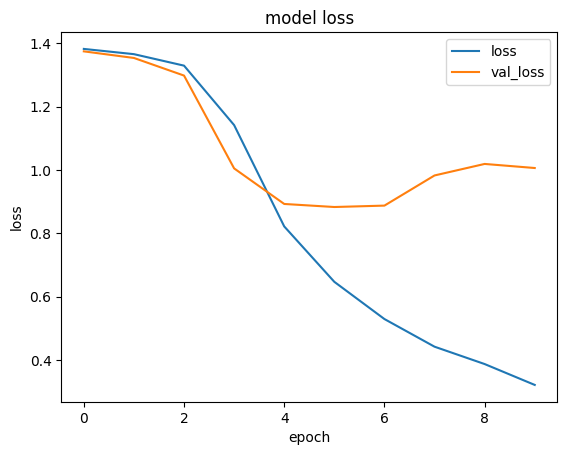

In [29]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

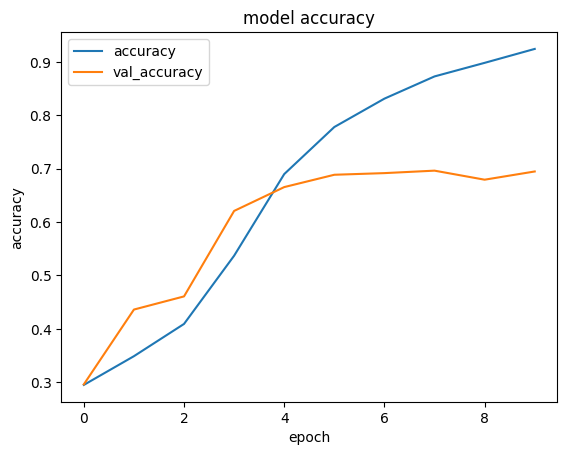

In [30]:
accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [32]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_generator.labels_df, axis=1)
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_true, y_pred, target_names=target_names))

11/41 [=======>......................] - ETA: 7s

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


41/41 [==============================] - 11s 253ms/step
              precision    recall  f1-score   support

     class 0       0.19      0.17      0.18       157
     class 1       0.20      0.19      0.19       166
     class 2       0.26      0.39      0.32       172
     class 3       0.24      0.14      0.18       153

    accuracy                           0.23       648
   macro avg       0.22      0.22      0.22       648
weighted avg       0.22      0.23      0.22       648



41/41 [==============================] - 10s 224ms/step


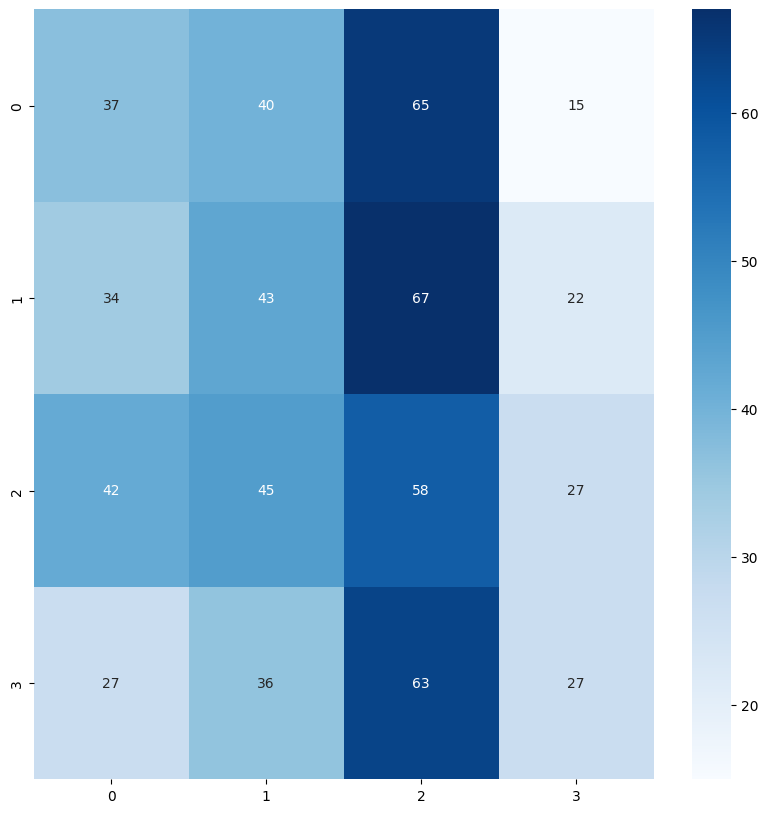

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_generator.labels_df, axis=1)
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.show()